In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import geopandas
import contextily
import random

# **Sieć komunikacji miejskiej miasta Wrocław**

**Źródła danych:**
* Dane odnośnie przystanków i czasu przejazdu: 
    * https://www.wroclaw.pl/open-data/dataset/rozkladjazdytransportupublicznegoplik_data
    * https://www.wroclaw.pl/linia-1-wroclaw (przykład dla linii 1)

**Opis danych:**
* Węzłami (wierzchołkami) są przystanki
* Połączeniami (krawędziami) są trasy pomiędzy przystankami (pojedyncza krawędź to przejazd autobusu/tramwaju z przystanku do przystanku)
* Krawędzie posiadają wagę, którą jest czas przejazdu danej linii od przystanku do przystanku

# **Pozyskiwanie danych**

In [2]:
routes = pd.read_csv("data/routes.txt")
stops = pd.read_csv("data/stops.txt")
trips = pd.read_csv("data/trips.txt")
stop_times = pd.read_csv("data/stop_times.txt")

In [3]:
# Niektóre połączenia nie miały opisów czasu trasy. W takim wypadku szukano połączeń w drugą stronę, które taki opis posiadały.
# Jeżeli wciąż nie znajdowano takich połączeń, to czas trasy losowano z przedziału [1, 3]
def fix_connections(connections):
    for connection in connections:
        time = connection['time']
        if time <= 0:
            source = connection['source']
            target = connection['target']
            for connection_2 in connections:
                source_2 = connection_2['source']
                target_2 = connection_2['target']
                time_2 = connection_2['time']
                if source_2 == target and target_2 == source and time_2 > 0:
                    connection['time'] = time_2
            if connection['time'] <= 0:
                connection['time'] = random.randint(1, 3) # Błędy w danych
        else:
            continue        
    return connections

# Scrappowanie czasu przejazdu
def find_times_row_route_direction(href):
    soup = BeautifulSoup(requests.get(href).content, "html.parser")
    table = soup.find('table', {'class': 'table table-bordered table-schedule hide-to-print'}).find('tbody')
    table_rows = table.findAll('tr')[1:]
    times = [row.findAll('td')[1].text for row in table_rows]
    times = [int(time) if len(time) > 0 else -1 for time in times]
    return times

# Scrappowanie połączeń
def get_connections(route_id):
    try:
        url = f"https://www.wroclaw.pl/linia-{str(route_id)}-wroclaw"
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        # find table with stops
        table = soup.find("table", {"class": "table table-bordered table-schedule"}).find("tbody")
        # find stops names in the table
        stops_names = table.findAll("a", {"class": "btn"})
        stops_names = [f"{stop.text}-{stop['href'].split('-')[-1]}" for stop in stops_names if stop.text != '']
        # find stops in specific directions
        direction_1 = [stops_names[i*2] for i in range(len(stops_names)//2)]
        direction_2 = [stops_names[i*2+1] for i in range(len(stops_names)//2)]
        # find times between stops
        dir1_href = 'https://www.wroclaw.pl' + table.find('a', {'class': 'btn btn-primary'})['href']
        dir2_href = 'https://www.wroclaw.pl' + table.find('a', {'class': 'btn btn-danger'})['href']
        dir1_times = find_times_row_route_direction(dir1_href)
        dir1_times = [time2 - time1 for time1, time2 in zip(dir1_times[:-1], dir1_times[1:])]
        dir2_times = find_times_row_route_direction(dir2_href)
        dir2_times = [time2 - time1 for time1, time2 in zip(dir2_times[:-1], dir2_times[1:])]
        # create directions stop1-stop2 for all stops
        direction_1_connections = [{'source': source, 'target': target, 'route_id': route_id, 'time': time} for source, target, time in zip(direction_1[:-1], direction_1[1:], dir1_times)]
        direction_2_connections = [{'source': source, 'target': target, 'route_id': route_id, 'time': time} for source, target, time in zip(direction_2[:-1], direction_2[1:], dir2_times)]
        # create all route connections: list of (source, target) elements
        route_connections = direction_1_connections + direction_2_connections
        route_connections = fix_connections(route_connections)
    except:
        route_connections = []
    return route_connections

In [4]:
route_ids = trips['route_id'].unique()

all_connections = []
for route_id in route_ids:
    all_connections.extend(get_connections(route_id))
    
routes_df = pd.DataFrame.from_dict(all_connections, orient='columns')
routes_df.to_csv("routes_df.csv", index=False)

In [5]:
# # Plot with geopandas
# gdf = geopandas.GeoDataFrame(stops, geometry=geopandas.points_from_xy(stops.stop_lon, stops.stop_lat), crs='EPSG:3857')
# ax = gdf.plot(markersize=1)
# contextily.add_basemap(ax, crs=gdf.crs.to_string())

# **Tworzenie grafu**

In [6]:
G = nx.from_pandas_edgelist(routes_df, edge_attr='time', create_using=nx.MultiDiGraph())
G2 = nx.from_pandas_edgelist(routes_df, edge_attr='time', create_using=nx.DiGraph())

In [7]:
n_G_edges, n_G2_edges = len(G.edges), len(G2.edges)
print(f"Przed usunięciem pętli i wielokrotnych krawędzi: {n_G_edges}")
print(f"Po usunięciu pętli i wielokrotnych krawędzi: {n_G2_edges}")
print(f"Ubyło {n_G_edges - n_G2_edges} krawędzi (pozostało {n_G2_edges/n_G_edges*100:.2f}% krawędzi)")

Przed usunięciem pętli i wielokrotnych krawędzi: 6382
Po usunięciu pętli i wielokrotnych krawędzi: 2716
Ubyło 3666 krawędzi (pozostało 42.56% krawędzi)


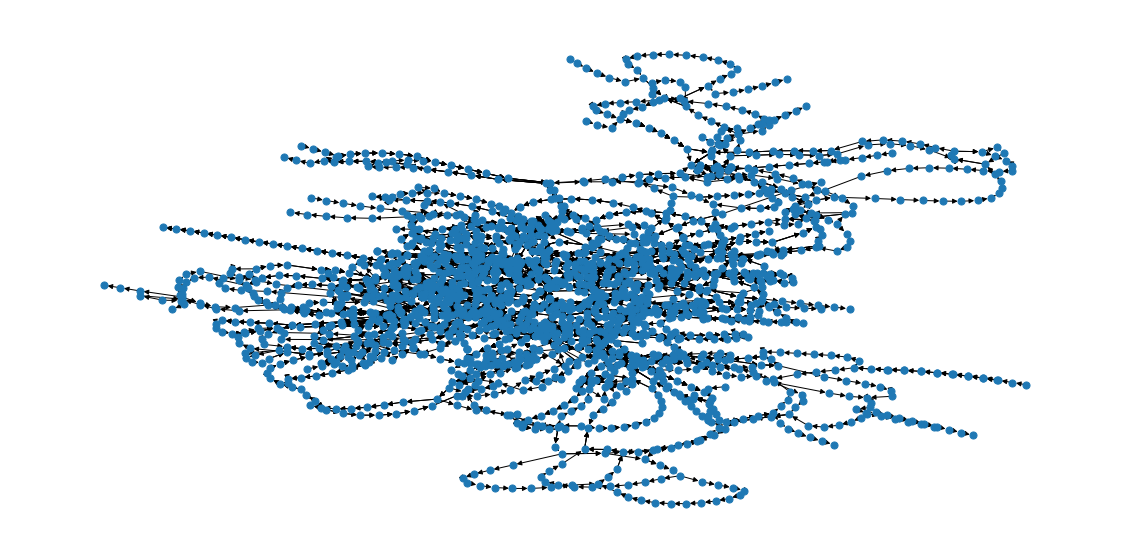

In [50]:
fig, ax = plt.subplots(figsize=(20, 10))
nx.draw_kamada_kawai(G2, node_size=50, ax=ax)

# **Analiza sieci**

## **Podstawowa analiza sieci**:
* rozkład stopni węzła
* rozkład najkrótszych ścieżek
* rozkład współczynnika grupowania
* średnica sieci
* liczba komponentów
* kluczowe węzły w sieci z punktu widzenia różnych miar
* do jakiego modelu sieci jest zbliżona nasza sieć (losowa, bezskalowa itd.)

#### rozkład stopni węzła

(array([1.378e+03, 4.550e+02, 1.760e+02, 5.800e+01, 2.900e+01, 9.000e+00,
        8.000e+00, 6.000e+00, 2.000e+00, 1.000e+00]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <BarContainer object of 10 artists>)

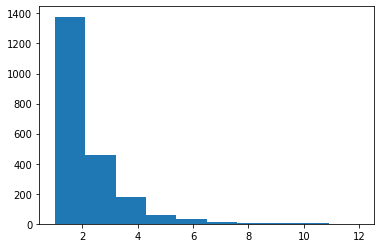

In [33]:
ax = plt.subplot()
ax.hist(dict(G2.degree()).values(), bins=10)

#### rozkład najkrótszych ścieżek

(array([2.10730e+04, 9.47010e+04, 2.70417e+05, 3.48586e+05, 4.80499e+05,
        4.43069e+05, 3.74472e+05, 2.36996e+05, 2.25582e+05, 1.61132e+05,
        1.04509e+05, 5.33120e+04, 4.06270e+04, 2.26500e+04, 1.19930e+04,
        4.97100e+03, 2.96200e+03, 1.03800e+03, 2.54000e+02, 2.90000e+01]),
 array([ 0.  ,  4.75,  9.5 , 14.25, 19.  , 23.75, 28.5 , 33.25, 38.  ,
        42.75, 47.5 , 52.25, 57.  , 61.75, 66.5 , 71.25, 76.  , 80.75,
        85.5 , 90.25, 95.  ]),
 <BarContainer object of 20 artists>)

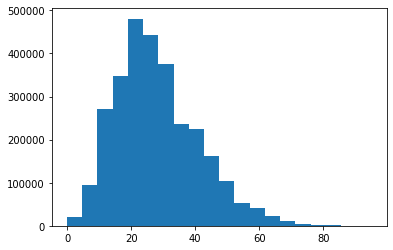

In [32]:
path_lengths = [list(x[1].values()) for x in list(nx.shortest_path_length(G2))]
path_lengths = [x for xs in path_lengths for x in xs]
plt.hist(path_lengths, bins=20)

#### rozkład współczynnika grupowania sieci

(array([1.916e+03, 2.200e+01, 2.200e+01, 4.800e+01, 1.000e+01, 5.000e+00,
        6.000e+01, 0.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.200e+01]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  ]),
 <BarContainer object of 20 artists>)

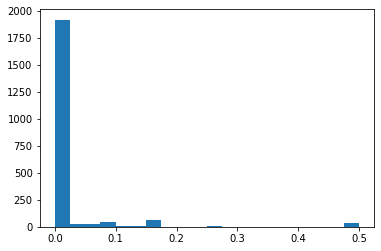

In [36]:
plt.hist(nx.clustering(G2).values(), bins=20)

#### liczba komponentów

In [49]:
print('komponenty silnie połączone:', len(list(nx.strongly_connected_components(G2))))
print('komponenty słabo połączone:', len(list(nx.weakly_connected_components(G2))))

komponenty silnie połączone: 340
komponenty słabo połączone: 2


Duża liczba komponentów silnie połączonych jest rezultatem osobnego zapisu w bazie danych przystanków w obie strony.

#### kluczowe węzły w sieci z punktu widzenia różnych miar

In [56]:
d = nx.closeness_centrality(G2)
sorted(d, key=d.get, reverse=True)[:10]

['GALERIA DOMINIKAŃSKA-10111',
 'GALERIA DOMINIKAŃSKA-10126',
 'skwer Krasińskiego-20337',
 'PL. JANA PAWŁA II-10501',
 'DWORZEC AUTOBUSOWY-11321',
 'Katedra-20909',
 'Ogród Botaniczny-20903',
 'Dyrekcyjna-21101',
 'PL. GRUNWALDZKI-20916',
 'Katedra-20931']

In [58]:
d = dict(nx.degree(G2))
sorted(d, key=d.get, reverse=True)[:10]

['DWORZEC AUTOBUSOWY-21121',
 'GALERIA DOMINIKAŃSKA-10126',
 'PL. JANA PAWŁA II-10501',
 'Arkady (Capitol)-10366',
 'Hallera-11304',
 'GALERIA DOMINIKAŃSKA-10111',
 'Psie Pole (Rondo Lotników Polskich)-29128',
 'Hallera-11303',
 'DWORZEC AUTOBUSOWY-21102',
 'KROMERA-24112']

In [59]:
d = nx.betweenness_centrality(G2)
sorted(d, key=d.get, reverse=True)[:10]

['Wejherowska-12315',
 'Kwiska-12318',
 'GALERIA DOMINIKAŃSKA-10126',
 'Psie Pole-29103',
 'Psie Pole (Rondo Lotników Polskich)-29128',
 'FAT-11707',
 'Wrocławski Park Technologiczny-12150',
 'Psie Pole-29104',
 'RUBCZAKA (Stacja kolejowa)-18390',
 'KROMERA-24102']

#### do jakiego modelu sieci jest zbliżona nasza sieć (losowa, bezskalowa itd.)

In [65]:
# print(np.mean(list(dict(nx.degree(G2)).values())))
# print(np.var(list(dict(nx.degree(G2)).values())))

## **Analiza grup w sieci**
* jakie grupy występują w naszej sieci
* ile ich jest, jak są połączone, jakiej są wielkości
* z czego może wynikać dany podział
* jak wygląda podział na grupy z punktu widzenia różnych algorytmów do ekstrakcji grup.

#### jakie grupy występują w naszej sieci

#### ile ich jest, jak są połączone, jakiej są wielkości

#### z czego może wynikać dany podział

#### jak wygląda podział na grupy z punktu widzenia różnych algorytmów do ekstrakcji grup.

## **Analiza wizualna sieci**
* różne layouty
* różne sposoby kolorowania, kształtu, wielkości wierzchołków 
    * w zależności od wartości poszczególnych miar
    * w zależności od podziału na grupy
* wizualizacja tylko wycinka sieci (np. jednej grupy) itd.

#### różne layouty

#### różne sposoby kolorowania, kształtu, wielkości wierzchołków

##### w zależności od wartości poszczególnych miar

##### w zależności od podziału na grupy

#### wizualizacja tylko wycinka sieci (np. jednej grupy) itd.

## **Analiza rozprzestrzeniania w sieci**
* jak rozprzestrzenia się informacja
* wpływ wirusa w Waszej sieci w zależności od różnych warunków np. 
    * jak wygląda proces gdy zaczniemy od wierzchołka X, Y, Z
    * jak wygląda proces gdy „zaszczepimy” węzły A, B, C
    * kogo musimy, zaszczepić/odizolować by w przypadku wybuchu epidemii w jednej grupie społecznej nie przedostała się ona do innych
    * co jeżeli mamy ograniczoną liczbę szczepionek albo szczepionki przychodzą partiami i danego dnia możemy zaszczepić ograniczoną liczbę osób itp.

#### jak rozprzestrzenia się informacja

#### wpływ wirusa w Waszej sieci w zależności od różnych warunków

##### jak wygląda proces gdy zaczniemy od wierzchołka X, Y, Z

##### jak wygląda proces gdy „zaszczepimy” węzły A, B, C

##### kogo musimy, zaszczepić/odizolować by w przypadku wybuchu epidemii w jednej grupie społecznej nie przedostała się ona do innych

##### co jeżeli mamy ograniczoną liczbę szczepionek albo szczepionki przychodzą partiami i danego dnia możemy zaszczepić ograniczoną liczbę osób itp.